In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random


from timm.models import create_model
from tqdm import tqdm
from torch import nn
from torch import optim
from torchvision import datasets, models, transforms
from sklearn import metrics

In [3]:
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Ivan\.cache\kagglehub\datasets\kritikseth\fruit-and-vegetable-image-recognition\versions\8


In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = create_model('vgg16', pretrained=True, num_classes=36) #create_model('resnet50', pretrained=True, num_classes=36)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        # transforms.ColorJitter(
        #     brightness=0.4,
        #     contrast=0.4,
        #     saturation=0.4),
        # transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [9]:
train_folder = f'{path}\\train'
val_folder = f'{path}\\validation'
test_folder = f'{path}\\test'

In [10]:
train_folder

'C:\\Users\\Ivan\\.cache\\kagglehub\\datasets\\kritikseth\\fruit-and-vegetable-image-recognition\\versions\\8\\train'

In [11]:
train_dataset = torchvision.datasets.ImageFolder(train_folder, train_transforms)
len(train_dataset)

3115

In [12]:
val_dataset = torchvision.datasets.ImageFolder(val_folder, val_transforms)
len(val_dataset)

351

In [13]:
test_dataset = torchvision.datasets.ImageFolder(test_folder, test_transforms)
len(test_dataset)

359

In [14]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


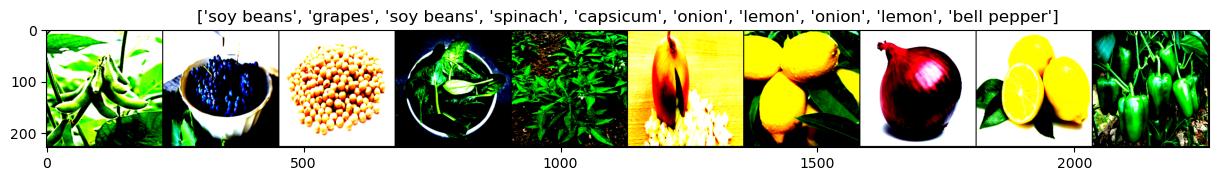

In [15]:
class_names = train_dataset.classes

inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs[:10], nrow=10)

plt.figure(figsize=(15, 5))
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.title([class_names[x] for x in classes[:10]])
plt.show()

In [16]:
train_dataset.class_to_idx

{'apple': 0,
 'banana': 1,
 'beetroot': 2,
 'bell pepper': 3,
 'cabbage': 4,
 'capsicum': 5,
 'carrot': 6,
 'cauliflower': 7,
 'chilli pepper': 8,
 'corn': 9,
 'cucumber': 10,
 'eggplant': 11,
 'garlic': 12,
 'ginger': 13,
 'grapes': 14,
 'jalepeno': 15,
 'kiwi': 16,
 'lemon': 17,
 'lettuce': 18,
 'mango': 19,
 'onion': 20,
 'orange': 21,
 'paprika': 22,
 'pear': 23,
 'peas': 24,
 'pineapple': 25,
 'pomegranate': 26,
 'potato': 27,
 'raddish': 28,
 'soy beans': 29,
 'spinach': 30,
 'sweetcorn': 31,
 'sweetpotato': 32,
 'tomato': 33,
 'turnip': 34,
 'watermelon': 35}

In [17]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [18]:
def validate(model, testloader, criterion, class_names):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item() 

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [19]:
n_epochs = 10
lr = 1e-4#0.025

In [20]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=0.01, factor=0.31, patience=7) #optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

In [21]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(n_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {n_epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, 
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_dataloader,  
                                                 criterion, class_names)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    scheduler.step(valid_epoch_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.51s/it]


Training loss: 1.295, training acc: 63.371
Validation loss: 0.429, validation acc: 84.900
--------------------------------------------------
[INFO]: Epoch 2 of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.53s/it]


Training loss: 0.572, training acc: 81.701
Validation loss: 0.404, validation acc: 88.604
--------------------------------------------------
[INFO]: Epoch 3 of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.52s/it]


Training loss: 0.355, training acc: 88.154
Validation loss: 0.231, validation acc: 93.162
--------------------------------------------------
[INFO]: Epoch 4 of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.53s/it]


Training loss: 0.271, training acc: 91.108
Validation loss: 0.206, validation acc: 93.447
--------------------------------------------------
[INFO]: Epoch 5 of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.50s/it]


Training loss: 0.292, training acc: 90.851
Validation loss: 0.325, validation acc: 90.883
--------------------------------------------------
[INFO]: Epoch 6 of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.53s/it]


Training loss: 0.239, training acc: 92.167
Validation loss: 0.259, validation acc: 91.168
--------------------------------------------------
[INFO]: Epoch 7 of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Training loss: 0.163, training acc: 94.478
Validation loss: 0.224, validation acc: 95.726
--------------------------------------------------
[INFO]: Epoch 8 of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:18<00:00,  1.71s/it]


Training loss: 0.099, training acc: 96.244
Validation loss: 0.227, validation acc: 95.157
--------------------------------------------------
[INFO]: Epoch 9 of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:18<00:00,  1.72s/it]


Training loss: 0.080, training acc: 97.689
Validation loss: 0.203, validation acc: 95.157
--------------------------------------------------
[INFO]: Epoch 10 of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:18<00:00,  1.73s/it]

Training loss: 0.117, training acc: 96.726
Validation loss: 0.206, validation acc: 96.581
--------------------------------------------------
TRAINING COMPLETE


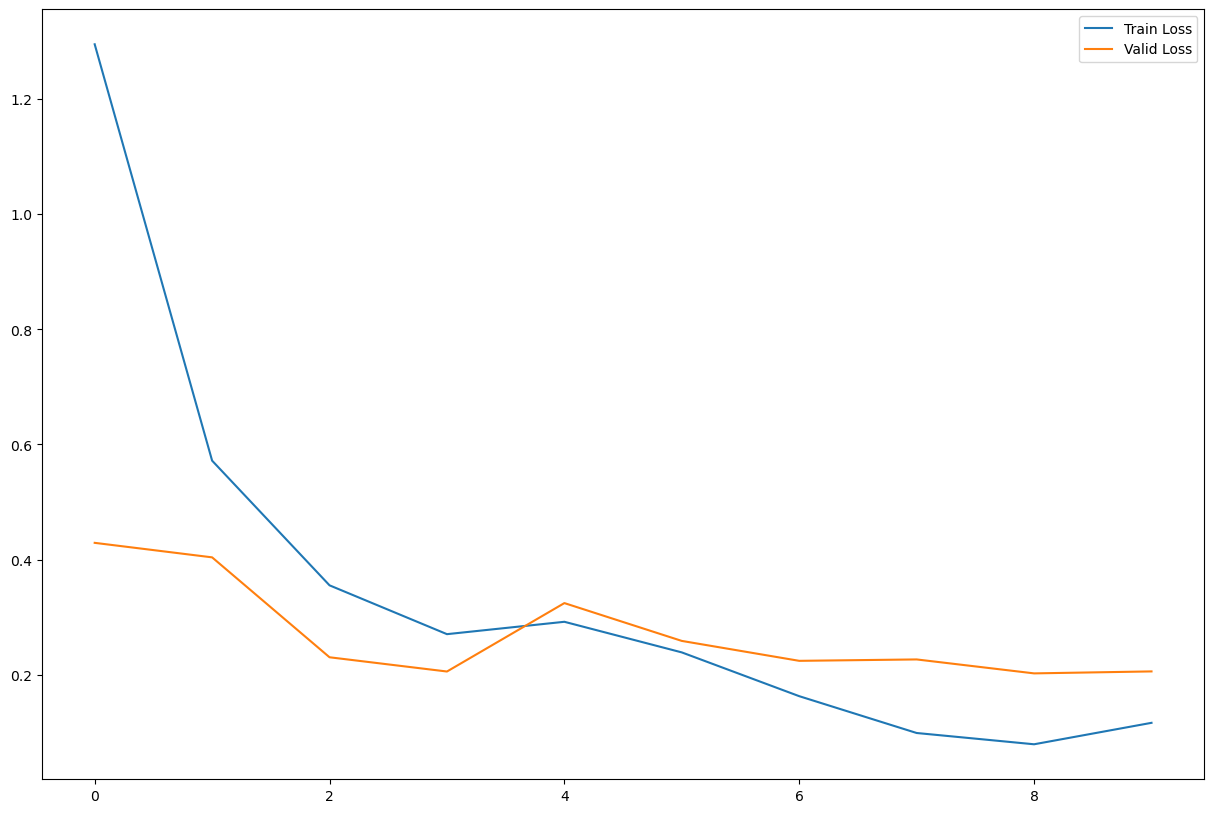

In [22]:
plt.figure(figsize=(15, 10))
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')
plt.legend()
plt.show()

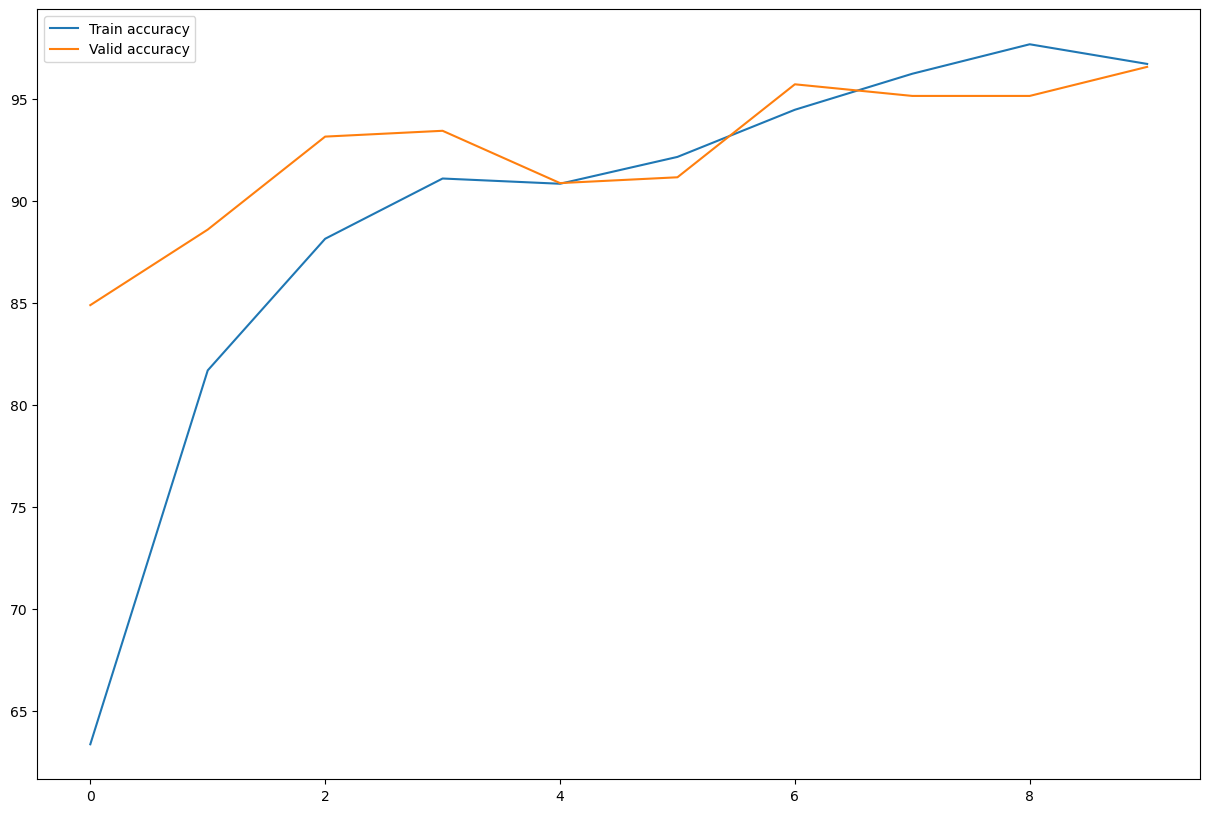

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(train_acc, label='Train accuracy')
plt.plot(valid_acc, label='Valid accuracy')
plt.legend()
plt.show()

In [24]:
test_loss, test_acc = validate(model, test_dataloader, criterion, class_names)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:19<00:00,  1.60s/it]


In [25]:
test_loss, test_acc

(0.18895269353136732, 96.65738161559888)

In [27]:
torch.save(model.state_dict(), 'vgg16_fruit_veg_classifier.pth')